In [32]:
import at
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
warnings.filterwarnings('ignore')

In [53]:
originalLattice = at.load_mat('C:\\Users\\shaun\\pipelines\\lattice-saves\\misaligned-bts-quads-correctors-100um-stddev-roll-100urad-stddev.mat')
# df = pd.read_csv('C:\\users\\shaun\\pipelines\\datadump\\2026-02-20__10-33-29.csv')
# df = pd.read_csv('C:\\users\\shaun\\pipelines\\datadump\\2026-02-20__12-01-21.csv')
# df = pd.read_csv('C:\\Users\\shaun\\pipelines\\datadump\\2026-02-20__12-26-30.csv')
# df = pd.read_csv('C:\\Users\\shaun\\pipelines\\datadump\\2026-02-20__14-17-37.csv')
# df = pd.read_csv('C:\\Users\\shaun\\pipelines\\datadump\\2026-02-20__14-24-14.csv')
# df = pd.read_csv('C:\\Users\\shaun\\pipelines\\datadump\\2026-02-20__14-36-33.csv')
df = pd.read_csv('C:\\Users\\shaun\\pipelines\\datadump\\2026-02-20__15-27-23.csv')

xBPMs:
-0.07529182194940225
0.9135595883374208
2.27753439520825
5.530378908479838
-0.5407655329389681
-8.013723204557666
-3.128963958662162
yBPMs:
0.28372009281027444
0.4197238299478898
0.6489112432356897
0.9599079320208936
0.44311626630636824
-0.17445812992793394
-0.7090538857038708


Text(0.5, 0.98, 'LTB First Four Steerer Pairs - Optimisation of Trajectory')

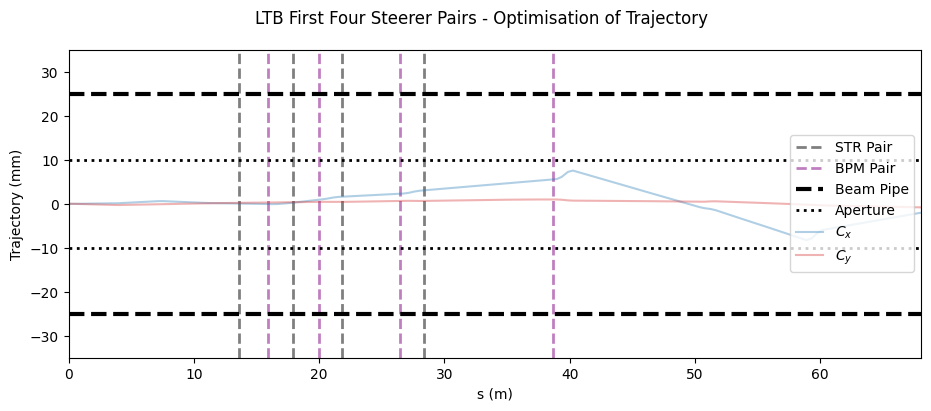

In [ ]:
lattice = deepcopy(originalLattice)

fig, ax = plt.subplots(figsize = (11, 4))
ax.set_xlabel('s (m)')
ax.set_ylabel('Trajectory (mm)')
ax.set_xlim(0, lattice.get_s_pos(-1))

numParticles = 2500
inputTwiss = {
    'betax': 3.731,
    'betay': 2.128,
    'alphax': -.0547,
    'alphay': -.1263,
    'emitx': 2.6e-7,
    'emity': 2.6e-7,
    'blength': 0,
    'espread': 0,
}
sigmaMat = at.sigma_matrix(**inputTwiss)

latticeHSTRs = at.get_refpts(lattice, 'HSTR')
latticeVSTRs = at.get_refpts(lattice, 'VSTR')
BPMs = at.get_refpts(lattice, 'BPM')

labelShown = False
for ID in latticeHSTRs[:4]:
    if not labelShown:
        labelShown = True
        ax.axvline(x = lattice.get_s_pos(ID), ls = '--', lw = 2, color = 'black', alpha = .5, label = 'STR Pair')
    else:
        ax.axvline(x = lattice.get_s_pos(ID), ls = '--', lw = 2, color = 'black', alpha = .5)

labelShown = False
for ID in BPMs[:4]:
    if not labelShown:
        labelShown = True
        ax.axvline(x = lattice.get_s_pos(ID), ls = '--', lw = 2, color = 'purple', alpha = .5, label = 'BPM Pair')
    else:
        ax.axvline(x = lattice.get_s_pos(ID), ls = '--', lw = 2, color = 'purple', alpha = .5)

ax.axhline(y = -25, ls = '--', lw = 3, color = 'black', label = 'Beam Pipe')
ax.axhline(y = 25, ls = '--', lw = 3, color = 'black')
ax.set_ylim(-35, 35)

ax.axhline(y = -10, ls = ':', lw = 2, color = 'black', label = 'Aperture')
ax.axhline(y = 10, ls = ':', lw = 2, color = 'black')

labelShown = False
for evaluation in range(df.shape[0]):
    print(f'step {evaluation + 1}/{df.shape[0]}', end = '\r', flush = True)
    row = evaluation
    HSTRCols = df.columns.str.contains(r'^HSTR')
    HSTRs = df.iloc[row, HSTRCols] * 1e-3
    VSTRCols = df.columns.str.contains(r'^VSTR')
    VSTRs = df.iloc[row, VSTRCols] * 1e-3

    for _, ID in enumerate(latticeHSTRs[:4]):
        lattice[ID].KickAngle[0] = HSTRs[_]
    for _, ID in enumerate(latticeVSTRs[:4]):
        lattice[ID].KickAngle[1] = VSTRs[_]

    beam = at.beam(numParticles, sigmaMat)
    pOut, *_ = lattice.track(beam, refpts = np.arange(len(lattice)), nturns = 1)
    if not labelShown:
        labelShown = True
        ax.plot([*lattice.get_s_pos(range(len(lattice)))], np.nanmean(pOut[0, :, :, 0], axis = 0) * 1e3, color = 'tab:blue', alpha = .35, label = r'$C_x$')
        ax.plot([*lattice.get_s_pos(range(len(lattice)))], np.nanmean(pOut[2, :, :, 0], axis = 0) * 1e3, color = 'tab:red', alpha = .35, label = r'$C_y$')
    else:
        ax.plot([*lattice.get_s_pos(range(len(lattice)))], np.nanmean(pOut[0, :, :, 0], axis = 0) * 1e3, color = 'tab:blue', alpha = .35)
        ax.plot([*lattice.get_s_pos(range(len(lattice)))], np.nanmean(pOut[2, :, :, 0], axis = 0) * 1e3, color = 'tab:red', alpha = .35)
    
ax.legend(loc = 'center right')
fig.suptitle('LTB First Four Steerer Pairs - Optimisation of Trajectory')